# import

In [55]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn import metrics
import scipy
from scipy import stats
import statsmodels as sm
from statsmodels.distributions.empirical_distribution import ECDF


# load data 

In [56]:
phat_path = r'C:\Users\w10\Desktop\웰컴\AS\8주차(데이터추가추출부터)\phat\seg1\ensemble'

In [57]:
os.listdir(phat_path)

['model_valid_phat_df.csv',
 'test_phat_df.csv',
 'train_phat_df.csv',
 'valid_phat_df.csv']

In [58]:
prob_train_df = pd.read_csv(os.path.join(phat_path, 'train_phat_df.csv'))
prob_valid_df = pd.read_csv(os.path.join(phat_path, 'valid_phat_df.csv'))
prob_test_df = pd.read_csv(os.path.join(phat_path, 'test_phat_df.csv'))
prob_model_valid_df = pd.read_csv(os.path.join(phat_path, 'model_valid_phat_df.csv'))

In [59]:
prob_train_df.head(2)

,no,BAD,ensemble_phat
0,1,1,0.467364
1,3,1,0.457814


# performance check

In [60]:
def get_accuracy(probs, labels, accu_thre=0.5):
    pred_labels = np.zeros(probs.shape)
    pred_labels[probs >= accu_thre] = 1.0
    accuracy = metrics.accuracy_score(labels, pred_labels)
    return accuracy

def get_ks_statistics(probs, labels):
    probs_pos = probs[labels == 1]
    probs_neg = probs[labels == 0]
    ks, ks_p_value = stats.ks_2samp(probs_pos, probs_neg)
    return ks, ks_p_value

def get_auc_ar(probs, labels):
    auc = metrics.roc_auc_score(labels, probs)
    ar = auc * 2 - 1
    return auc, ar

class Performances:
    def __init__(self, probs, labels, accu_thre=0.5):
        accuracy = get_accuracy(probs, labels, accu_thre=accu_thre)
        ks, ks_p_value = get_ks_statistics(probs, labels)
        auc, ar = get_auc_ar(probs, labels)
        self.accuracy = accuracy
        self.ks = ks * 100  # percent
        self.ks_p_value = ks_p_value
        self.auc = auc * 100  # percent
        self.ar = ar * 100  # percent

In [61]:
prob_train = prob_train_df['ensemble_phat'].values
prob_valid = prob_valid_df['ensemble_phat'].values
prob_test = prob_test_df['ensemble_phat'].values
prob_model_valid = prob_model_valid_df['ensemble_phat'].values

In [62]:
result_train = Performances(prob_train, prob_train_df['BAD'])
result_valid = Performances(prob_valid, prob_valid_df['BAD'])
result_test = Performances(prob_test, prob_test_df['BAD'])
# result_model_valid = Performances(prob_train, prob_train_df['BAD'])

In [63]:
print('Train KS : {0:=^10.3f} / AUC : {1:=^10.3f} / AR : {2:=^10.3f}'.format(result_train.ks, result_train.auc, result_train.ar))
print('valid KS : {0:=^10.3f} / AUC : {1:=^10.3f} / AR : {2:=^10.3f}'.format(result_valid.ks, result_valid.auc, result_valid.ar))
print('Test KS : {0:=^10.3f} / AUC : {1:=^10.3f} / AR : {2:=^10.3f}'.format(result_test.ks, result_test.auc, result_test.ar))

Train KS : ==35.431== / AUC : ==73.870== / AR : ==47.740==
valid KS : ==32.880== / AUC : ==72.356== / AR : ==44.712==
Test KS : ==34.565== / AUC : ==73.191== / AR : ==46.382==


In [64]:
# KS plotting ftn
def KS_compute_with_plot(prob, data_type):

    GOOD_p = prob[data_type == 0]
    BAD_p = prob[data_type == 1]

    ks = stats.ks_2samp(GOOD_p, BAD_p)

    ecdf_0 = ECDF(GOOD_p)
    ecdf_1 = ECDF(BAD_p)
    
    good_p_df = pd.DataFrame({'phat' : ecdf_0.x, 'good_cdf' : ecdf_0.y,})
    bad_p_df = pd.DataFrame({'phat' : ecdf_1.x, 'bad_cdf' : ecdf_1.y})

    p_df = pd.merge(good_p_df, bad_p_df, on = ['phat'], how = 'outer',indicator = True)

    p_df.sort_values(by = ['phat'], ascending = True, inplace = True)
    p_df = p_df.fillna(method = 'ffill')

    p_df['ks'] = np.abs(p_df['good_cdf'] - p_df['bad_cdf'])

    plt.plot(p_df['phat'], p_df['ks'], label = 'KS', )
    plt.plot(ecdf_0.x, ecdf_0.y, label="GOOD")
    plt.plot(ecdf_1.x, ecdf_1.y, label='BAD')
    # plt.xlim(0, 0.3)

    plt.ylabel('CDF')
    plt.xlabel('p')
    plt.title('KS : {:.3f}'.format(ks[0] * 100))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    return (ks[0])

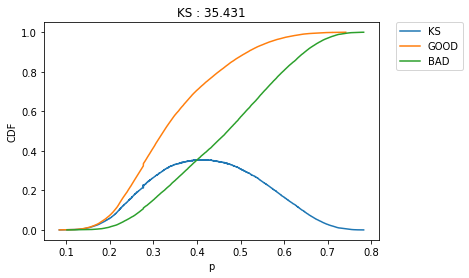

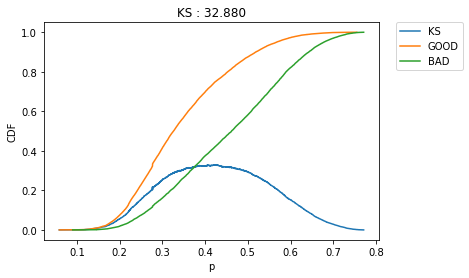

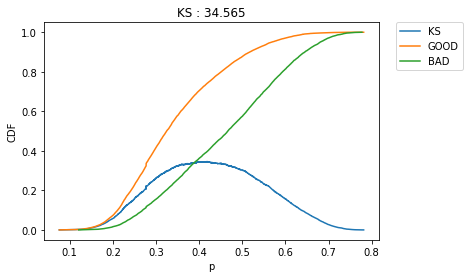

0.34564916447487876

In [65]:
KS_compute_with_plot(prob_train, prob_train_df['BAD'])
KS_compute_with_plot(prob_valid, prob_valid_df['BAD'])
KS_compute_with_plot(prob_test, prob_test_df['BAD'])

# 등급화

### 100타일

In [82]:
q = np.linspace(0,1,101)
prob_train_df['bad_phat_interval'] = pd.qcut(x = prob_train_df['ensemble_phat'].values, q = q, duplicates = 'drop', precision = 50)

In [83]:
max_interval = np.max(prob_train_df['bad_phat_interval'])
min_interval = np.min(prob_train_df['bad_phat_interval'])

change_max_interval = pd.Interval(left = max_interval.left, right = 1.0)
change_min_interval = pd.Interval(left = -np.inf, right = min_interval.right)

prob_train_df['bad_phat_interval'] = np.where(prob_train_df['bad_phat_interval'] == max_interval,
                                             change_max_interval,
                                             prob_train_df['bad_phat_interval'] )

prob_train_df['bad_phat_interval'] = np.where(prob_train_df['bad_phat_interval'] == min_interval,
                                             change_min_interval,
                                             prob_train_df['bad_phat_interval'] )

In [84]:
interval_points = pd.Categorical(prob_train_df['bad_phat_interval']).categories

In [85]:
len(interval_points)
interval_points

IntervalIndex([(-inf, 0.156], (0.156, 0.172], (0.172, 0.183], (0.183, 0.192], (0.192, 0.2] ... (0.643, 0.654], (0.654, 0.668], (0.668, 0.685], (0.685, 0.708], (0.708, 1.0]],
              closed='right',
              dtype='interval[float64]')

In [86]:
prob_valid_df['bad_phat_interval'] = pd.cut(x = prob_valid_df['ensemble_phat'].values, bins = interval_points, duplicates = 'drop')

In [87]:
prob_test_df['bad_phat_interval'] = pd.cut(x = prob_test_df['ensemble_phat'].values, bins = interval_points, duplicates = 'drop')

In [88]:
prob_model_valid_df['bad_phat_interval'] = pd.cut(x = prob_model_valid_df['ensemble_phat'].values, bins = interval_points, duplicates = 'drop')

In [89]:
def phat_grade_df(prob_df, bad_interval_col):
    grp_grade = prob_df.groupby(by = [bad_interval_col], as_index = False).agg(
    {
        'BAD' : ['count','sum']
    })
    grp_grade.columns = ['phat_interval', 'Total', 'Bad']
    
    grp_grade['Good'] = grp_grade['Total'] - grp_grade['Bad']
    grp_grade['Bad_rate'] = grp_grade['Bad'] / grp_grade['Total']
    
    grp_grade['Distribution Good'] = grp_grade['Good'] / grp_grade['Good'].sum()
    grp_grade['Distribution Bad'] = grp_grade['Bad'] / grp_grade['Bad'].sum()
    grp_grade['Distribution Total'] = grp_grade['Total'] / grp_grade['Total'].sum()
    
    grp_grade['Cum Good'] = np.cumsum(grp_grade['Good'])
    grp_grade['Cum Bad'] = np.cumsum(grp_grade['Bad'])
    grp_grade['Cum Total'] = np.cumsum(grp_grade['Total'])

    grp_grade['Cum Dist Good'] = np.cumsum(grp_grade['Good']) / grp_grade['Good'].sum()
    grp_grade['Cum Dist Bad'] = np.cumsum(grp_grade['Bad']) / grp_grade['Bad'].sum()
    grp_grade['Cum Dist Total'] = np.cumsum(grp_grade['Total']) / grp_grade['Total'].sum()
    grp_grade['Cum Bad rate'] = grp_grade['Cum Bad'] / grp_grade['Cum Total']
    
    grp_grade['WoE'] = np.log(grp_grade['Distribution Good'] / grp_grade['Distribution Bad'])
    grp_grade = grp_grade.replace({'WoE' : {np.inf : 0, -np.inf : 0}})
    grp_grade['IV'] = (grp_grade['Distribution Good'] - grp_grade['Distribution Bad']) * grp_grade['WoE']
    grp_grade['KS'] = np.abs(grp_grade['Cum Dist Good'] - grp_grade['Cum Dist Bad'])*100

    grp_grade.reset_index( inplace = True)

    grp_grade.rename(columns = {'index' : 'grade'}, inplace = True)
    grp_grade['grade'] = grp_grade['grade'] + 1
    
    return grp_grade

In [90]:
train_phat_grade = phat_grade_df(prob_train_df, 'bad_phat_interval')
valid_phat_grade = phat_grade_df(prob_valid_df, 'bad_phat_interval')
test_phat_grade = phat_grade_df(prob_test_df, 'bad_phat_interval')
model_valid_phat_grade = phat_grade_df(prob_model_valid_df, 'bad_phat_interval')

In [91]:
train_phat_grade['phat_left'] = train_phat_grade['phat_interval'].apply(lambda x : x.left)
train_phat_grade['phat_right'] = train_phat_grade['phat_interval'].apply(lambda x : x.right)

In [92]:
valid_phat_grade['phat_left'] = valid_phat_grade['phat_interval'].apply(lambda x : x.left)
valid_phat_grade['phat_right'] = valid_phat_grade['phat_interval'].apply(lambda x : x.right)

In [93]:
test_phat_grade['phat_left'] = test_phat_grade['phat_interval'].apply(lambda x : x.left)
test_phat_grade['phat_right'] = test_phat_grade['phat_interval'].apply(lambda x : x.right)

In [94]:
model_valid_phat_grade['phat_left'] = model_valid_phat_grade['phat_interval'].apply(lambda x : x.left)
model_valid_phat_grade['phat_right'] = model_valid_phat_grade['phat_interval'].apply(lambda x : x.right)

In [95]:
# left < x <= right
train_phat_grade

,grade,phat_interval,Total,Bad,Good,Bad_rate,Distribution Good,Distribution Bad,Distribution Total,Cum Good,...,Cum Total,Cum Dist Good,Cum Dist Bad,Cum Dist Total,Cum Bad rate,WoE,IV,KS,phat_left,phat_right
0,1,"(-inf, 0.156]",736,53,683,0.072011,0.015568,0.001787,0.010009,683,...,736,0.015568,0.001787,0.010009,0.072011,2.164816,0.029835,1.378157,-inf,0.156
1,2,"(0.156, 0.172]",735,79,656,0.107483,0.014953,0.002663,0.009996,1339,...,1471,0.030521,0.004450,0.020005,0.089735,1.725326,0.021204,2.607116,0.156,0.172
2,3,"(0.172, 0.183]",735,82,653,0.111565,0.014885,0.002764,0.009996,1992,...,2206,0.045406,0.007215,0.030000,0.097008,1.683471,0.020404,3.819123,0.172,0.183
3,4,"(0.183, 0.192]",736,102,634,0.138587,0.014451,0.003439,0.010009,2626,...,2942,0.059857,0.010653,0.040009,0.107410,1.435689,0.015811,4.920395,0.183,0.192
4,5,"(0.192, 0.2]",735,124,611,0.168707,0.013927,0.004180,0.009996,3237,...,3677,0.073785,0.014834,0.050005,0.119663,1.203429,0.011730,5.895071,0.192,0.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,"(0.643, 0.654]",735,608,127,0.827211,0.002895,0.020498,0.009996,43549,...,70591,0.992660,0.911671,0.959991,0.383080,-1.957375,0.034455,8.098880,0.643,0.654
96,97,"(0.654, 0.668]",736,635,101,0.862772,0.002302,0.021408,0.010009,43650,...,71327,0.994963,0.933079,0.970000,0.388030,-2.229891,0.042604,6.188314,0.654,0.668
97,98,"(0.668, 0.685]",735,640,95,0.870748,0.002165,0.021576,0.009996,43745,...,72062,0.997128,0.954656,0.979995,0.392953,-2.298978,0.044625,4.247215,0.668,0.685
98,99,"(0.685, 0.708]",735,667,68,0.907483,0.001550,0.022487,0.009996,43813,...,72797,0.998678,0.977142,0.989991,0.398148,-2.674669,0.055999,2.153547,0.685,0.708


In [54]:
save_path = os.path.join(r'C:\Users\w10\Desktop\웰컴\AS\8주차(데이터추가추출부터)\모형등급화\seg1', 'prob_100tile.xlsx')

with pd.ExcelWriter(save_path) as writer:
    train_phat_grade.to_excel(writer,sheet_name='train', index = False)
    valid_phat_grade.to_excel(writer,sheet_name='valid', index = False)
    test_phat_grade.to_excel(writer,sheet_name='test', index = False)
    model_valid_phat_grade.to_excel(writer,sheet_name='model_valid', index = False)